В цьому домашньому завданні кожне завдання оцінюється по 10 балів.

 **Завдання 1.** Після перегляду лекцій про поняття функії, вступ до лінійної алгебри і мат. формулювання лін. регресії знайдіть найкращу лінію для прогнозу `charges` за `age` **для некурців** (датафрейм `non_smoker_df`) з допомогою

1. Методу МНК (з використанням тільки `numpy`, без `scikit learn`)

2. Full-Batch градієнтного спуску з `numpy` . Протестуйте 3 різних learning rate і зробіть висновок, який є найкращим виходячи з практик для цього, наведених в лекції. Зверніть увагу, що на вхід треба набір даних дворозміний, для цього можливо треба буде трансформувати Ваші дані X в формат, як був в лекції "Математичне формулювання лінійної регресії". Також, градієнтний спуск в нашому випадку може розходитись з навчальним рейтом 0.1, бо цей рейт в цій задачі завеликий. Спробуйте нижчі рейти.
3. З `scikit-learn.LinearRegression`. Тут зверніть увагу, що вхід `X` має бути двовимірним масивом, тому нам потрібно передати dataframe, а не окрему колонку. Якщо у Вас X - колонка (а у Вас так мало б бути), то можна скористатись `X.to_frame()` щоб конвертувати колонку в датафрейм.

Для кожного методу
- знайдіть і виведіть коефіцієнти моделі
- обчисліть прогнози моделі і збережіть в окрему змінну
- порахуйте точність прогнозу RMSE  

Для градієнтного спуску виведіть графік помилки в залежності від ітерації.

А також побудуйте на одному графіку дані `age` проти `charges` в вигляді діаграми розсіювання і всі три лінії регресії, знайдені кожним з методів (для град. спуску оберіть варіант з тим learning rate, який виявився найкращим).

Зробіть висновки, чи відрізняються результати моделей?
Чи є знайдены параметри моделы близькими до ваших найкращих припущень?

# Task 1 Solution

In [34]:
import pandas as pd
import numpy as np

medical_df = pd.read_csv('data/medical-charges.csv')
non_smoker_df = medical_df[medical_df.smoker == 'no']

In [35]:
non_smoker_df.head()

,age,sex,bmi,children,smoker,region,charges
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160


## Define functions

In [36]:
def fit_least_squares_method(X, y, fit_intercept=False):
    """
    Fit a linear regression model using Least Squares Method aka Ordinary Least Squares (OLS).
    """
    if fit_intercept:
        X = np.hstack([np.ones((X.shape[0], 1)), X])

    coefs = np.linalg.inv(X.T @ X) @ X.T @ y

    return coefs, X

def rmse(targets, predictions):
    return np.sqrt(np.mean((targets - predictions) ** 2))

def mae(targets, predictions):
    return np.mean(np.abs(targets - predictions))

def predict(W, X):
    return X @ W


In [37]:
def gradient_function(f, h=1e-5, central=True):
    """
    Create and return a function that computes the numerical derivative or gradient of f.
    """
    def grad_f(x):
        x = np.asarray(x, dtype=float)
        grad = np.zeros_like(x)

        for i in range(len(x)):
            e = np.zeros_like(x)
            e[i] = h

            if central:
                grad[i] = (f(x + e) - f(x - e)) / (2 * h)
            else:
                grad[i] = (f(x + e) - f(x)) / h

        return grad

    return grad_f


def batch_gradient_descent(
    loss_f,
    init_w,
    lr=0.01,
    epochs=1000,
    epsilon=1e-6,
    return_history=False,
    grad_f=None,
    h=1e-5,
    central=True
):
    """
    Perform gradient descent optimization with early stopping.
    """
    if grad_f is None:
        grad_f = gradient_function(loss_f, h=h, central=central)

    w = np.asarray(init_w, dtype=float)
    history = []

    for _ in range(epochs):
        grad = grad_f(w)

        # Compute gradient norm
        grad_norm = np.linalg.norm(grad)

        # Early stopping condition
        if grad_norm < epsilon:
            break

        w -= lr * grad

        if not np.all(np.isfinite(w)):
            raise FloatingPointError("Divergence detected")

        if return_history:
            history.append((w.copy(), loss_f(w), grad_norm))

    return (w, history) if return_history else w



## Least Squares Method

In [38]:
X_raw = non_smoker_df[['age']].to_numpy()
y_raw = non_smoker_df['charges'].to_numpy()

In [39]:
w_ols, X = fit_least_squares_method(X_raw, y_raw, fit_intercept=True)
w0_ols, w1_ols = w_ols

y_pred_ols = predict(w_ols, X)
rmse_ols = rmse(y_raw, y_pred_ols)
mae_ols = mae(y_raw, y_pred_ols)

print(f'Least Squares Methods:\n Intercept: {w0_ols},\n Coef: {w1_ols},\n RMSE: {rmse_ols},\n MAE: {mae_ols}')

Least Squares Methods:
 Intercept: -2091.4205565650805,
 Coef: 267.24891283119973,
 RMSE: 4662.505766636395,
 MAE: 2580.5232282116103


## Gradient Descent

### No scaling

In [40]:
# add bias column
X = np.hstack([np.ones((X_raw.shape[0], 1)), X_raw])
y = y_raw

# mse gradient function
def grad_mse_fun(W):
    n = X.shape[0]
    return (2 / n) * X.T @ (X @ W - y)

# Loss function
def loss_func(W):
    return np.mean((X @ W - y) ** 2)

# Gradient descent - No scaling - lr=1e-6
w_gd_lr_6, history_gd_lr_6 = batch_gradient_descent(
    loss_func,
    grad_f=grad_mse_fun,
    init_w=[0, 0],
    lr=1e-6,
    epsilon=1e-6,
    epochs=1000,
    return_history=True
)

w0_gd_lr_6, w1_gd_lr_6 = w_gd_lr_6

y_pred_gd_lr_6 = predict(w_gd_lr_6, X)

rmse_gd_lr_6 = rmse(y_raw, y_pred_gd_lr_6)
mae_gd_lr_6 = mae(y_raw, y_pred_gd_lr_6)

print(f'Gradient Descent lr=1e-6:\n Intercept: {w0_gd_lr_6},\n Coef: {w1_gd_lr_6},\n RMSE: {rmse_gd_lr_6},\n MAE: {mae_gd_lr_6}')

Gradient Descent lr=1e-6:
 Intercept: 4.33124916239435,
 Coef: 213.4575690658104,
 RMSE: 4723.647721473958,
 MAE: 2673.7508497456024


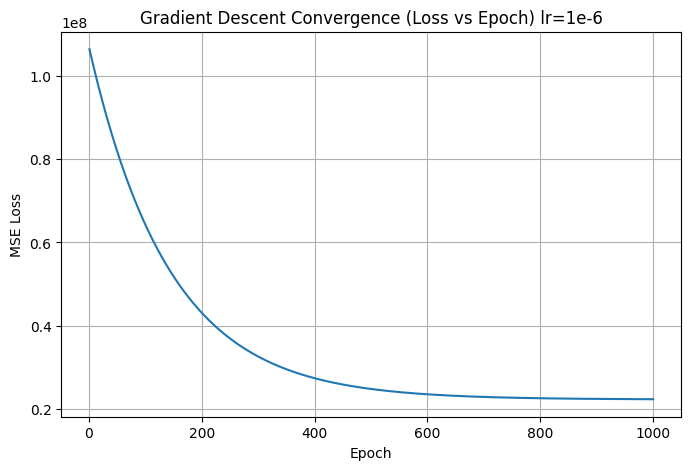

In [41]:
import matplotlib.pyplot as plt

def plot_gd_convergence(losses, epochs, title="Gradient Descent Convergence (Loss vs Epoch)"):
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, losses)
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title(title)
    plt.grid(True)
    plt.show()

losses = [entry[1] for entry in history_gd_lr_6]
epochs = range(1, len(losses) + 1)

plot_gd_convergence(losses, epochs, title="Gradient Descent Convergence (Loss vs Epoch) lr=1e-6")

In [42]:
# Gradient descent - No scaling - lr=1e-4
w_gd_lr_4, history_gd_lr_4 = batch_gradient_descent(
    loss_func,
    grad_f=grad_mse_fun,
    init_w=[0, 0],
    lr=1e-4,
    epsilon=400,
    epochs=100,
    return_history=True
)
w0_gd_lr_4, w1_gd_lr_4= w_gd_lr_4

y_pred_gd_lr_4 = predict(w_gd_lr_4, X)
rmse_gd_lr_4 = rmse(y_raw, y_pred_gd_lr_4)
mae_gd_lr_4 = mae(y_raw, y_pred_gd_lr_4)

print(f'Gradient Descent lr=1e-4:\n Intercept: {w0_gd_lr_4},\n Coef: {w1_gd_lr_4},\n RMSE: {rmse_gd_lr_4},\n MAE: {mae_gd_lr_4}')

Gradient Descent lr=1e-4:
 Intercept: 0.21295826871672457,
 Coef: 220.15455659787733,
 RMSE: 4715.349747703003,
 MAE: 2809.436201719748


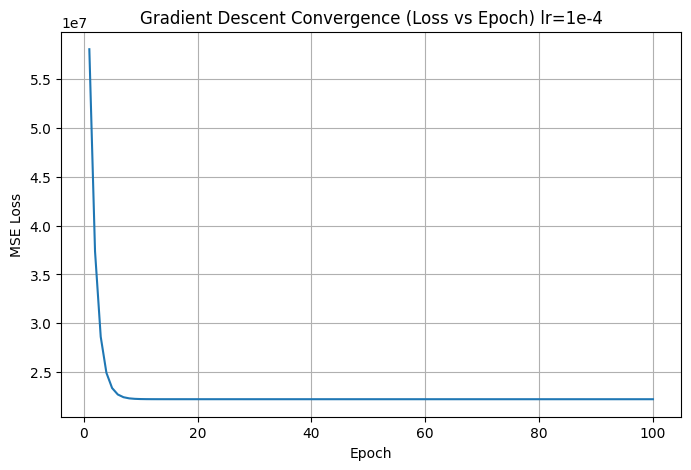

In [43]:
losses = [entry[1] for entry in history_gd_lr_4]
epochs = range(1, len(losses) + 1)

plot_gd_convergence(losses, epochs, title="Gradient Descent Convergence (Loss vs Epoch) lr=1e-4")

In [44]:
# Gradient descent - No scaling - lr=1e-3
# grad_f=None cause with grad_f=grad_mse_fun Divergence detected Error
w_gd_lr_3 = batch_gradient_descent(
    loss_func,
    grad_f=None,
    init_w=[0, 0],
    lr=1e-3,
    epsilon=1e-6,
    epochs=1000
)
w0_gd_lr_3, w1_gd_lr_3= w_gd_lr_3
w0_gd_lr_3, w1_gd_lr_3

# Gradient descent diverge with lr=1e-3 and no scaling, no sense to make predictions with that result

(np.float64(33482234410.938835), np.float64(-152960432678.3591))

### Scale feature and target / Re-scale W

With scaling and rescaleing approach I achived to get the same values as with least squares method

In [45]:
# scale features
X_scaled = (X_raw - X_raw.mean(axis=0)) / X_raw.std(axis=0)

# scale target
y_scaled = (y_raw - y_raw.mean()) / y_raw.std()

# add bias column
X = np.hstack([np.ones((X_scaled.shape[0], 1)), X_scaled])
y = y_scaled

# Gradient descent
w_gd, history_gd = batch_gradient_descent(
    loss_func,
    grad_f=grad_mse_fun,
    init_w=[0, 0],
    lr=0.01,
    epsilon=1e-4,
    epochs=1000,
    return_history=True
)

w0_gd_scaled, w1_gd_scaled = w_gd

# convert back to original y units
w1_gd = w1_gd_scaled * (y_raw.std() / X_raw.std()) # slope
w0_gd = y_raw.mean() + w0_gd_scaled * y_raw.std() - w1_gd * X_raw.mean() # intercept

# use original X values and add bias columns for correct matrix product
X_pred = np.hstack([np.ones((X_raw.shape[0], 1)), X_raw])

y_pred_gd = predict(np.array([w0_gd, w1_gd]), X_pred)
rmse_gd = rmse(y_raw, y_pred_gd)
mae_gd = mae(y_raw, y_pred_gd)

print(f'Gradient Descent scale both feature and target, lr=0.01:\n Intercept: {w0_gd},\n Coef: {w1_gd},\n RMSE: {rmse_gd},\n MAE: {mae_gd}')

Gradient Descent scale both feature and target, lr=0.01:
 Intercept: -2090.5963160618794,
 Coef: 267.22798523382903,
 RMSE: 4662.505775943115,
 MAE: 2580.5307192124883


In [46]:
len(history_gd)

468

### GD plot lines

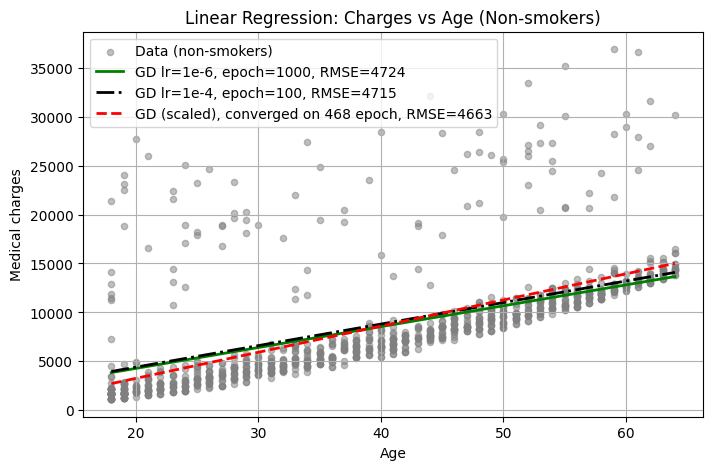

In [47]:
def plot_lines(
    ws,
    labels,
    styles=None,
    X_raw=X_raw,
    y=y_raw,
    title="Linear Regression: Charges vs Age (Non-smokers)",
    scatter_label="Data (non-smokers)",
    scatter_color="Grey",
    xlabel="Age",
    ylabel="Medical charges"
):
    """
    Plot data scatter and multiple fitted regression lines with optional styles.

    Parameters
    ----------
    ws : list of array-like
        List of weight vectors [w0, w1]
    labels : list of str
        Labels for each line (same length as ws)
    styles : list of dict, optional
        Line styles for each line. Each dict can have keys like 'color', 'linestyle', 'linewidth'.
        If None, default matplotlib styles are used.
    X_raw : np.ndarray
        Feature array of shape (n_samples, 1)
    y : np.ndarray
        Target values
    """
    assert len(ws) == len(labels), "ws and labels must have the same length"
    if styles is not None:
        assert len(styles) == len(ws), "styles must have same length as ws"

    # Flatten X for plotting
    x = X_raw.ravel()
    x_line = np.linspace(x.min(), x.max(), 200)

    plt.figure(figsize=(8, 5))

    # Scatter plot
    plt.scatter(
        x, y,
        alpha=0.5,
        label=scatter_label,
        color=scatter_color,
        s=20
    )

    # Plot each regression line
    for i, (W, label) in enumerate(zip(ws, labels)):
        y_line = W[0] + W[1] * x_line
        style = styles[i] if styles is not None else {}
        plt.plot(x_line, y_line, label=label, **style)

    # Labels and formatting
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


ws = [
    w_gd_lr_6,
    w_gd_lr_4,
    np.array([w0_gd, w1_gd]),
]

labels = [
    f"GD lr=1e-6, epoch=1000, RMSE={rmse_gd_lr_6:.0f}",
    f"GD lr=1e-4, epoch=100, RMSE={rmse_gd_lr_4:.0f}",
    f"GD (scaled), converged on 468 epoch, RMSE={rmse_gd:.0f}",
]

styles = [
    {"color": "g", "linestyle": "-", "linewidth": 2},
    {"color": "k", "linestyle": "-.", "linewidth": 2},
    {"color": "r", "linestyle": "--", "linewidth": 2},
]

plot_lines(ws, labels, styles=styles)


## scikit-learn.LinearRegression

In [48]:
from sklearn.linear_model import LinearRegression
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_raw, y_raw)

w0_sl, w1_sl = (lin_reg_model.intercept_, lin_reg_model.coef_[0])

# add bias columns for correct matrix product
X_pred = np.hstack([np.ones((X_raw.shape[0], 1)), X_raw])

y_pred_sl = predict(np.array([w0_sl, w1_sl]), X_pred)
rmse_sl = rmse(y_raw, y_pred_sl)
mae_sl = mae(y_raw, y_pred_sl)

print(f'Scikit learn LinearRegression:\n Intercept: {w0_gd},\n Coef: {w1_gd},\n RMSE: {rmse_gd},\n MAE: {mae_gd}')

Scikit learn LinearRegression:
 Intercept: -2090.5963160618794,
 Coef: 267.22798523382903,
 RMSE: 4662.505775943115,
 MAE: 2580.5307192124883


## Plots and compare

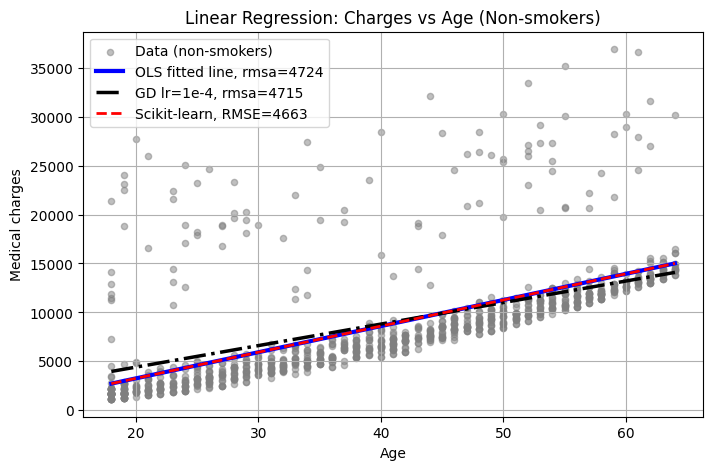

In [49]:
ws = [
    w_ols,
    w_gd_lr_4,
    np.array([w0_sl, w1_sl]),
]

labels = [
    f"OLS fitted line, rmsa={rmse_gd_lr_6:.0f}",
    f"GD lr=1e-4, rmsa={rmse_gd_lr_4:.0f}",
    f"Scikit-learn, RMSE={rmse_gd:.0f}",
]

styles = [
    {"color": "b", "linestyle": "-", "linewidth": 3},
    {"color": "k", "linestyle": "-.", "linewidth": 2.5},
    {"color": "r", "linestyle": "--", "linewidth": 2},
]

plot_lines(ws, labels, styles=styles)

<span style="background-color: #f60">Відповідь:</span><br/>
 - Результати моделей, отриманих методом найменших квадратів (МНК) з використанням лише numpy, та scikit-learn.LinearRegression не відрізняються, що є очікуваним результатом, оскільки обидва підходи використовують однакові аналітичні формули для обчислення оптимальних коефіцієнтів.
 - Для моделі, яка навчається за допомогою градієнтного спуску, складніше досягти найкращих можливих параметрів. Проте за умови правильного вибору learning rate отриманий результат загалом не набагато гірший, ніж у випадку використання МНК.
 - Водночас при застосуванні градієнтного спуску існує ризик отримати повністю некоректний результат у разі вибору неправильного (зокрема, надто великого) learning rate. У такому випадку, замість збіжності до оптимальних значень параметрів, їхні значення починають розбігатися та прямувати до нескінченності.
 - Для методу градієнтного спуску вдалося досягти найкращих можливих параметрів (ідентичних результатам МНК) лише після нормалізації значень X та y перед пошуком параметрів і подальшої денормалізації знайдених параметрів після завершення навчання.


 **Завдання 2.** Навчіть модель лінійної регресії з допомогою sklearn оцінювати розмір медичних збори для **курців** за їх віком.
Виведіть
- точність моделі
-  коефіцієнти
-  візуалізуйте модель у вигляді лінії на графіку розсіювання `age` проти `charges`

і зробіть висновки, чи це хороша модель, чи ви б її використовували в компанії?

In [50]:
medical_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [51]:
smoker_df = medical_df[medical_df.smoker == 'yes']

X_smoker_raw = smoker_df[['age']]
y_smoker_raw = smoker_df['charges']

In [52]:
from sklearn.linear_model import LinearRegression
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_smoker_raw, y_smoker_raw)

w0_smoker, w1_smoker = (lin_reg_model.intercept_, lin_reg_model.coef_[0])

# add bias columns for correct matrix product
X_smoker_pred = np.hstack([np.ones((X_smoker_raw.shape[0], 1)), X_smoker_raw])

y_smoker_pred = predict(np.array([w0_smoker, w1_smoker]), X_smoker_pred)
rmse_smoker = rmse(y_smoker_raw, y_smoker_pred)
mae_smoker = mae(y_smoker_raw, y_smoker_pred)

print(f'Smokers Scikit learn LinearRegression:\n Intercept: {w0_smoker},\n Coef: {w1_smoker},\n RMSE: {rmse_smoker},\n MAE: {mae_smoker}')

Smokers Scikit learn LinearRegression:
 Intercept: 20294.12812691597,
 Coef: 305.23760210982874,
 RMSE: 10711.00334810241,
 MAE: 10097.80057785873


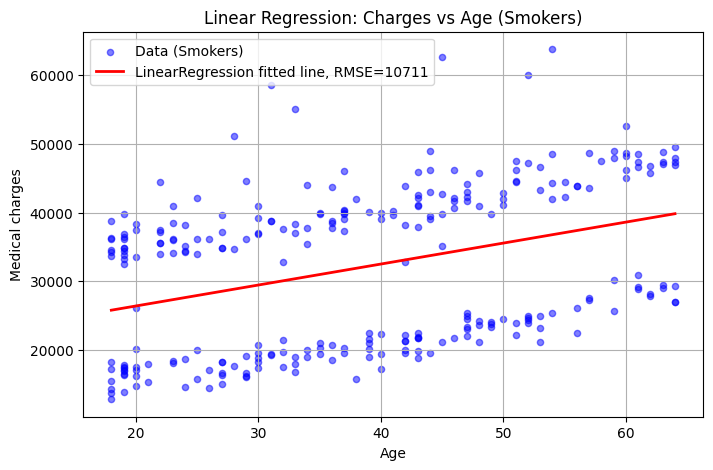

In [53]:
ws = [
    np.array([w0_smoker, w1_smoker]),
]

labels = [
    f"LinearRegression fitted line, RMSE={rmse_smoker:.0f}",
]

styles = [
    {"color": "r", "linestyle": "-", "linewidth": 2},
]

plot_lines(
    ws, labels, styles=styles, X_raw=X_smoker_raw.to_numpy(), y=y_smoker_raw.to_numpy(),
    title="Linear Regression: Charges vs Age (Smokers)",
    scatter_label="Data (Smokers)",
    scatter_color="Blue"
)

<span style="background-color: #f60">Відповідь:</span><br/>
 - Дані для курців мають значний розкид, і з наведеного вище графіка видно, що їх можна чітко розділити на дві окремі групи. Виглядає так, що побудова двох окремих моделей для цих груп дозволила б отримати значно кращі результати прогнозування. Тому я б не рекомендував використовувати поточну модель без змін, а радше продовжити аналіз і дослідження даних з метою побудови більш точної моделі з використанням додаткових параметрів.